# 2) Spectral Graph Analysis of the Digital Reconstruction of the Brain

In this notebook spectral graph theory's techniques are used to explore the connectivity matrix of the microcircuit.

We'll proceed by the following steps: 

- compute weights for the adjacency matrix of the microcircuit

- compute the combinatorial and the normalized Laplacian of the connectivity matrix of the microcircuit.

- compute the first 100 smallest eigenvalues and eigenvectors of the Laplacians.

- explore the clusters given by the sign of the Fiedler of the normalized Laplacian and other clusters.

- check if the given clusters classify the neuron by biological or structural properties.



In [0]:
##force not printing
%%capture 
%matplotlib inline
!pip install h5py
import numpy as np
import numpy.ma as ma
import h5py 
from scipy import sparse
import IPython.display as ipd
import matplotlib.pyplot as plt
import matplotlib.colors as col
from mpl_toolkits.mplot3d import Axes3D
import re
import networkx as nx
import scipy as sp
import scipy.sparse as sps
from scipy.sparse import coo_matrix, hstack, vstack, csr_matrix
from sklearn.cluster import KMeans
import sklearn.metrics as skm
import json


In [0]:
##read .h5 file format containing the information about the microcolumn of the averege individual. 
file_name='cons_locs_pathways_mc2_Column.h5'
h5=h5py.File(file_name,'r')


## 2.0) Weighted adjacency matrix

We upload the saved symmetric connectivity matrix computed in the notebook 1_ntds_project.ipynb in the file 'conn_matrix.h5'.

[Download here the already computed symmetric connectivity matrix](https://drive.google.com/uc?export=download&id=17VJ5Jwo6j-x-hKJbiuEe2Ltauz906LGJ)

In [0]:
##read .h5 file format containing the symmetric connection matrix
file_name='conn_matrix.h5'
h5_conn=h5py.File(file_name,'r')
conn_tot=h5_conn['binary']

In [0]:
N=conn_tot.shape[0]
m_values=list(h5['populations'].keys())


In [5]:
s=1 - float(np.count_nonzero(conn_tot))/N**2
print('The sparsity of the symmetric connectivity matrix is {}'.format(s))

The sparsity of the symmetric connectivity matrix is 0.984308506189


### 2.0.1) Weights with the euclidean distance

First, we'll compute the euclidean distance between our neurons using their 3D coordinates. Then we would like to have a strong edge if the distance is short and a light weight if the distance is large. In order to achive this, we'll use the Gaussian kernel:
$$\mathbf{W}(u,v) = \exp \left( \frac{-d^2(u, v)}{\sigma^2} \right),$$
where $\sigma$ is a parameter controlling the width of the kernel.


Moreover, we'd like to have and edge if and only if also a structural connection beween the neurons exists. Therefore, we'll use the computed connectivity matrix as a mask on the weighted matrix.

The following is the code used for computing the weighted adjacency matrix. For memory reasons we computed the matrix once and saved it as .h5 file.

In [0]:
def matrix_distances(m_values):
  locations=[]
  for x in m_values:
    locations.extend(list(h5['populations'][ x ]['locations']))
  distances =sp.spatial.distance.squareform(sp.spatial.distance.pdist(locations, 'euclidean'))
  c=1-np.array(conn_tot)
  kernel_width = distances.mean()
  weights =sp.exp(-(distances ** 2) / (kernel_width ** 2))
  np.fill_diagonal(weights, 0)
  weights= ma.masked_array(weights, mask=c)
  r=weights.filled(0) 
  return r
#distances=matrix_distances(m_values)

[Download here the already computed weighted matrix](https://www.dropbox.com/s/7jc20sr0gw2k7bc/dist_matrix_kernel.h5?dl=1)

In [0]:
##load already computed weighted matrix
file_name='dist_matrix_kernel.h5'
h5_dist=h5py.File(file_name,'r')
conn_dist=h5_dist['values']

### 2.0.2) Weights with the average failure of connection

---



For building this second weighted matrix we'll use the physiology information contained in the file [pathways_physiology_factsheets_simplified.json](https://bbp.epfl.ch/nmc-portal/downloads). The JSON file shows for each pair of morphological types the average failure rate of a connection: defined as ['an event when a presynaptic stimulus fails to evoke a posynaptic response'](https://bbp.epfl.ch/nmc-portal/microcircuit#/pathway/L1_HAC-L23_BTC).

For each structural connection, we'll use this value as a weight. Since this weight is strong when two neurons are well connected and light when the connection is weak, it's not necessary to change them with the Gaussian kernel.

The followig is the code for building the weighted matrix:

In [0]:
with open('pathways_physiology_factsheets_simplified.json','r') as json_file:
    json_data = json.load(json_file)

failure=dict()
keys=[]
for x in range(len(json_data.keys())):
  keys.append(list(json_data.keys())[x].split(':'))
  failure[list(json_data.keys())[x]]=json_data[list(json_data.keys())[x]]['failures_mean']

all_stri=set(list(json_data.keys()))
for x in m_values: 
  for y in m_values: 
    stri= x+':'+y
    if stri not in all_stri:
        failure[stri]=1

##Build again the network: rows are source of the signal, columns are target
def buildnetwork(m_values):
  for x in m_values: 
    for y in m_values:
      stri= x+':'+y
      v=failure[stri]
      if y == m_values[0]:
        conn_tot_row=v*coo_matrix(h5['connectivity'][x][y]['cMat']) 
      else:
        conn_temp_row=v*coo_matrix(h5['connectivity'][x][y]['cMat'])
        conn_tot_row = hstack((conn_tot_row, conn_temp_row))
    if x == m_values[0]:
      conn_tot = conn_tot_row
    else:
      conn_tot =vstack((conn_tot, conn_tot_row)) 
  print('The shape should be #neuronsx#neurons={}x{}, and we have: {}'.format(N,N,conn_tot.shape) )  
  conn_tot=coo_matrix(np.maximum(conn_tot.toarray(), conn_tot.toarray().T))
  return conn_tot
#conn_fail=buildnetwork(m_values)

We computed the weighted matrix once and saved it as an h5 file:

[Download here the already computed weighted matrix](https://drive.google.com/uc?export=download&id=1HLiRD93k9gq0oJbpm5IYRlhqB5j3j98O)

In [0]:
##load already computed weighted matrix
file_name='fail_weight.h5'
h5_dist=h5py.File(file_name,'r')
conn_fail=h5_dist['weight']


In [0]:
##scipy sparse matrix of conn_fail
conn_fail=csr_matrix(conn_fail)

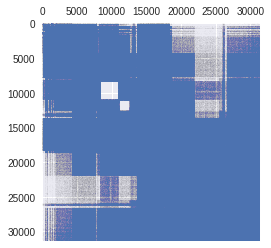

In [11]:
plt.spy(conn_fail, markersize = 0.06)
plt.show()

## 2.1) Laplacian Matrix and its spectrum 

### NOTE: From now on all the cells are run using the unweighted connectivity matrix. The following computations have been tested also with the failures weighted matrix generating similar outputs. However, we'll show how some of the results are improved by replacing the unweighted matrix with the weighted matrix in notebook 2.1. Regarding the distances weighted matrix, the computations were not successfull due to memory reasons.

In this section we'll compute the combinatorial and the normalized Laplacian of the connectivity matrix of the microcircuit.

In [12]:
##Normal Laplacian
conn_tot=csr_matrix(conn_tot,dtype=float)
laplacian_norm=sp.sparse.csgraph.laplacian(conn_tot,normed=True)
##Combinatorial Laplacian
laplacian=sp.sparse.csgraph.laplacian(conn_tot,normed=False)

/usr/local/lib/python2.7/dist-packages/scipy/sparse/csgraph/_laplacian.py:72: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if normed and (np.issubdtype(csgraph.dtype, int)


In [0]:
##Compute the first 100 eigenvalues and eigenvectors of the Laplacian
evalues, evect =sp.sparse.linalg.eigsh(laplacian,k=100,which="SM")
evalues_norm, evect_norm =sp.sparse.linalg.eigsh(laplacian_norm,k=100,which="SM")

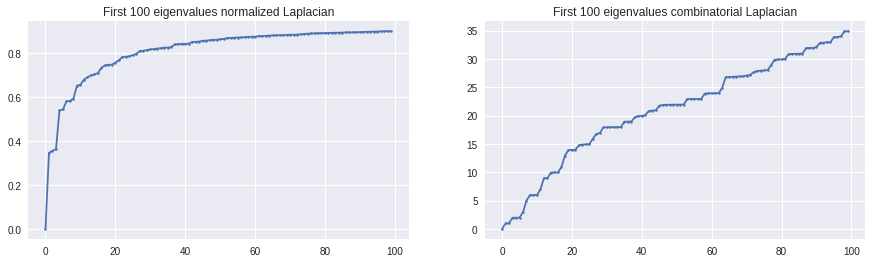

In [14]:
plt.figure(figsize=(15,4))

plt.subplot(1, 2, 1)
plt.title('First 100 eigenvalues normalized Laplacian')
plt.plot(evalues_norm, '.-', markersize=5)

plt.subplot(1, 2, 2)
plt.title('First 100 eigenvalues combinatorial Laplacian')
plt.plot(evalues, '.-', markersize=5);


plt.show()

 As the Laplacian is positive-semidefinite (PSD), **the eigenvalues are non-negative**:
\begin{equation*}
0 =\lambda_1 \leq \lambda_2 \leq ... \leq \lambda_n
\end{equation*} </font>

Moreover, for the normalized Laplacian we know that for every eigenvalues $\lambda_i$:
$$0 \leq \lambda_i \leq 2 $$

Finally, since $\lambda_0 =0 $ we know that **our network is connected**.

Now, we would like to know what is **the optimal dimension for the embedding using the Laplacian eigenmaps**. A common criterion is to **use the eigengaps**, that is the difference between two consecutive eigenvalues:
$$\gamma_k= \lambda_{k+1}-\lambda_{k}.$$

A high value of $\gamma_k$ means that there exists a good partition into at least $k$ clusters.

In our case it's easy to see that the optimal $k$s are:

- 3 for the normalized Laplacian.
- 2 for the combinatorial Laplacian.

For this reason, first we'll visualize a 2 and 3 dimensionl embedding with Laplacian eigenmaps of the network using both the combinatorial and normalized Laplacian. These embeddings should reveal the presence of clusters in our network.

## 2.2) 2D and 3D Embeddings of the Microcircuit with Laplacian eigenmaps

In [0]:
## set the coordinates for the embedding
##Normalized Laplacian
x_norm = evect_norm[:,1]
y_norm = evect_norm[:,2]
z_norm = evect_norm[:,3]
##Combinatorial Laplacian
x = evect[:,1]
y = evect[:,2]
z = evect[:,3]

In [0]:
##Plot embeddings with color label
def singleplt2dembeddings(x,y,col1,colmap=None,size=0.3,title1='Embedding with normalized Laplacian eigenmaps'):
  plt.figure(figsize=(15,5))

  plt.title(title1)
  plt.scatter(x, y,c=col1,cmap=colmap, alpha=0.6,s=size)
  plt.xlabel('Eigenvector 1')
  plt.ylabel('Eigenvector 2')
  plt.colorbar()
 
def plt2dembeddings(x,y, x1,y1,col1,col2,colmap=None,size=0.3,title1='Embedding with normalized Laplacian eigenmaps',title2='Embedding with combinatorial Laplacian eigenmaps'):
  plt.figure(figsize=(18,4))
  plt.subplot(1, 2, 1)
  plt.title(title1)
  plt.scatter(x, y,c=col1,cmap=colmap, alpha=0.6,s=size)
  plt.xlabel('Eigenvector 1')
  plt.ylabel('Eigenvector 2')
  if colmap !=None:
    plt.colorbar()
  plt.subplot(1, 2, 2)
  plt.title(title2)
  #plt.axis([-0.0001,0.0001,0.00001,0.000071])
  plt.axis([-0.0000711,0.000071,-0.00008,0.000025])
  plt.xlabel('Eigenvector 1')
  plt.ylabel('Eigenvector 2')
  if colmap !=None:
    plt.colorbar()
  plt.scatter(x1, y1,c=col2, cmap=colmap, alpha=0.5,s=10)
  
def plt3dembeddings(col=None,colmap=None):
  fig = plt.figure(figsize=(18,4))
  ax = fig.add_subplot(121, projection='3d')
  ax.scatter(x_norm,y_norm, z_norm, s=0.5,c=col,cmap=colmap)
  ax = fig.add_subplot(122, projection='3d')
  ax.scatter(x,y, z, s=5,c=col,cmap=colmap)
  #plt.axis([-0.0000511,-0.000011,-0.00003,0.000015])
  #ax.set_zlim3d(-0.0003,0.0002)
  #plt.axis([-0.00000511,0.0011,-0.00003,0.000015])
  plt.axis([-0.0003,0.0001,-0.00006,0.00001])
  ax.set_zlim3d(-0.00005,0.0003)
  
  
  
def plthist(value,face='g'):
    plt.figure(figsize=(10,4))
    plt.hist(value, bins=50 , facecolor=face,edgecolor='black', linewidth=1.2)
    plt.show()
def twoplthist(value1,value2, face='g',tit1=' ',tit2=' '):
    plt.figure(figsize=(15,3))
    plt.subplot(1,2,1)
    plt.hist(value1, bins=50 , facecolor=face,edgecolor='black', linewidth=1.2)
    plt.title(tit1)
    plt.subplot(1,2,2)
    plt.hist(value2, bins=50 , facecolor=face,edgecolor='black', linewidth=1.2)
    plt.title(tit2)
    plt.show()

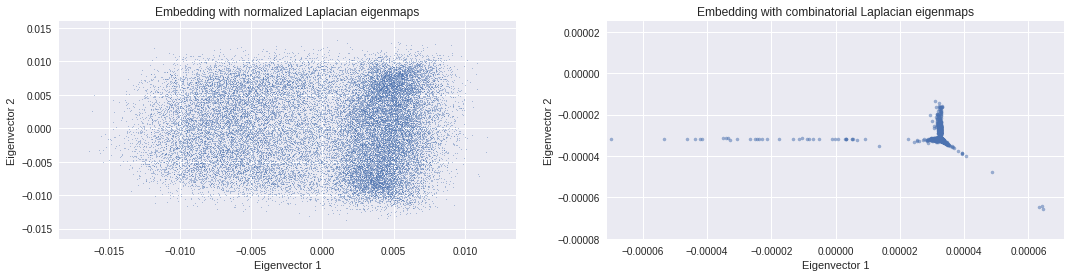

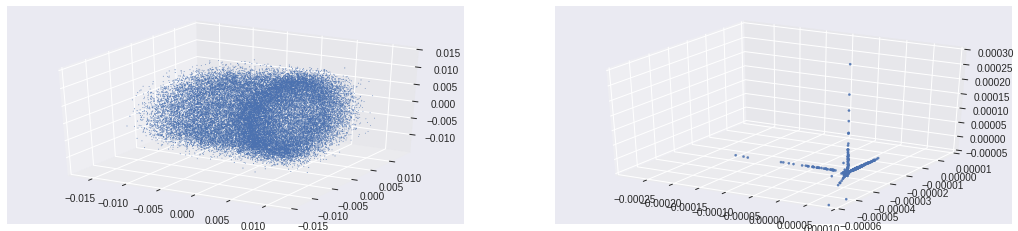

In [17]:
plt2dembeddings(x_norm,y_norm,x,y,col1=None, col2=None,colmap=None)
plt3dembeddings(col=None)

**Comments:** The embedding of the combinatorial Laplacian shows us an arrengment of the neurons along 3 main axes.
On the other hand, the embedding of the normalized Laplacian shows us a more compact cloud shape of neurons with density changing along the first axis. 

## 2.3) Spectral Clustering of the Microcircuit Network

In this section we'll focus on finding **two clusters inside our network.**

The **clusters** will be computed in the following ways:

- using the sign of the Fiedler vector.
- using the k-mean algorithm with k=2. 

**Note** For accuracy of the k-mean algorithm we had to delete 4 points in the embedding of the combinatorial Laplacian. These ponts are located far away from the 'core' of the embedding and could't give us a good partition of the network with the k-mean algorithm. 

In [0]:
#Delete points too far away from the 'core' of the embedding of the combinatorial Laplacian
X=np.column_stack((x,y))
X1=np.array([w for w in X if np.abs(w[0])<0.02 and np.abs(w[1])<0.002])
x1 = X1[:,0]
y1 = X1[:,1]
#k-mean algorithm  (k=2) for the combinatorial Laplacian 
kmeans = KMeans(n_clusters=2, init='random').fit(X1)
lab=kmeans.labels_
#k-mean algorithm for the normalized Laplacian
Xnorm=np.column_stack((x_norm,y_norm))
kmeans = KMeans(n_clusters=2, init='random').fit(Xnorm)
labnorm=kmeans.labels_


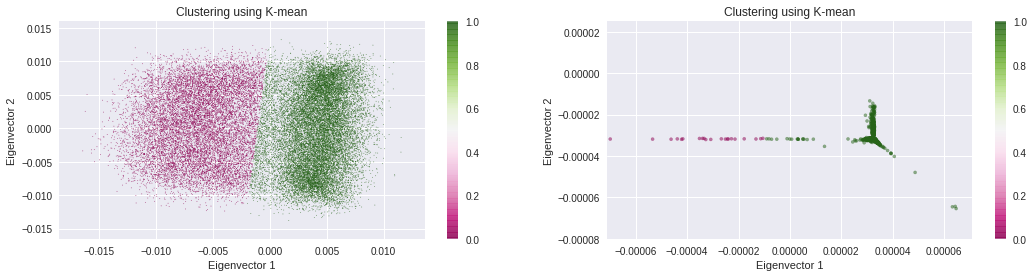

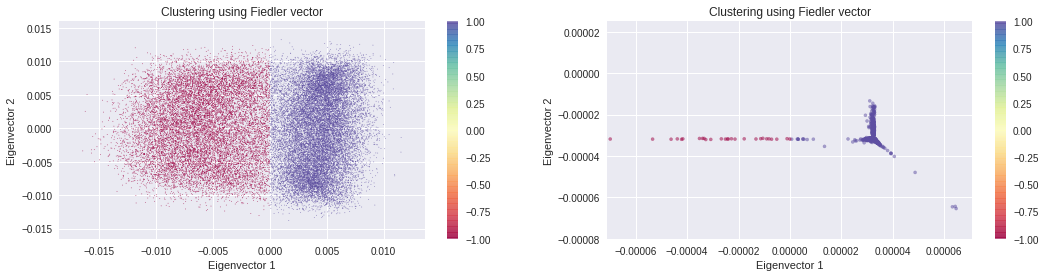

In [19]:
plt2dembeddings(x_norm,y_norm,x1,y1, col1=labnorm, col2=lab,colmap='PiYG',title1='Clustering using K-mean',title2='Clustering using K-mean')
sign=np.sign(evect_norm[:,1])
labels_norm = [sign]
labels = [np.sign(evect[:,1])]
plt2dembeddings(x_norm,y_norm,x,y, col1=labels_norm[0], col2=labels[0],colmap='Spectral',title1='Clustering using Fiedler vector',title2='Clustering using Fiedler vector')


**Comments :** In both cases for the combinatorial and normalized Laplacian the k-mean algorithm and the Fiedler vector give very similar partitions.

In [20]:
for i in range(len(lab)):
  if labnorm[i]==0:
    labnorm[i]=-1
err=np.count_nonzero(labnorm - sign)
err = min(err,N-err)
print('The partition given by the K-mean algorithm and the sign of the Fiedler vector differ for {} points'.format(err))

The partition given by the K-mean algorithm and the sign of the Fiedler vector differ for 986 points


## 2.4) Clusters exploration

In this sections we'll explore whether there exist different biological and/or structural features between the neurons in the clusters. 

We'll focus not only on the previous two clusters but we'll look also for other possible classifications given by the spectral coordinates.

### 2.4.1)Signal Flow-based clustering

This first attempt to classify the neurons was inspired by [the embedding with Laplacian eigenmaps of the neurons of the C.Elegans network](http://www.wormatlas.org/neuronalwiring.html). Our goal is to compute for each node a value similar to what they call [processing depth](http://www.wormatlas.org/ver1/durbinv1.2/chapter8.html#tth_sEc8.3). The latter is an indicator of how 'strongly' the signal flows out from a node. Moreover, this values seems to be correlated with the coordinates of the second eigenvector. Therefore, we guess it's a potential good candidate for classifying our neurons using the spectral coordinates. 



For computational reasons, since the difference in size between our network and the C.Elegans one (279x279), we didn't reorder our nodes as in the algorithm of the processing depth. Instead we used the in- and out- degree to characterize the strength of each neuron's signal flow in the following way:

$$\textbf{Total Flow}= \text{Out-Degree - In-Degree} $$



[Download here the already computed directed matrix](https://drive.google.com/uc?export=download&id=1YjdOKGsvImSZDf1ZfjmYKUBXr0vOj8_5)

In [0]:
#read .h5 file format containing the not symmetric directed connection matrix
file_name='conn_matrix_directed.h5'
h5_conn_dir=h5py.File(file_name,'r')
conn_tot_dir=h5_conn_dir['binary']

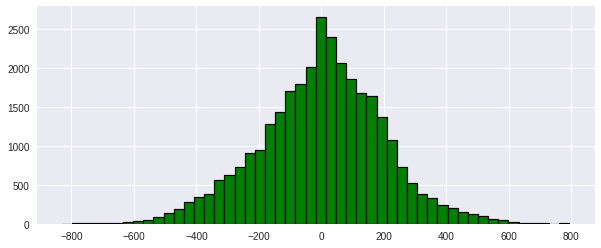

In [22]:
#Computing total flow
out_degree=np.sum(conn_tot_dir, axis=1)
in_degree=np.sum(conn_tot_dir, axis=0)
diff_out_in=out_degree-in_degree #total flow
tot_degree=in_degree+out_degree #total degree
plthist(diff_out_in)

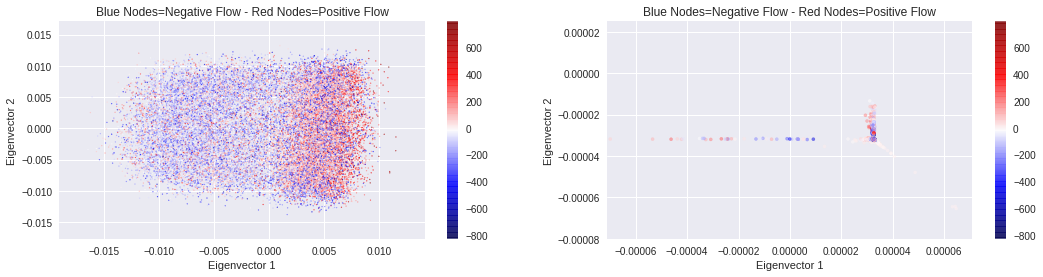

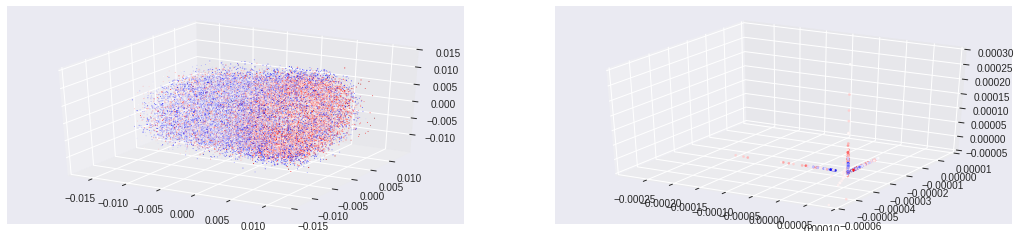

In [23]:
plt2dembeddings(x_norm,y_norm,x,y, col1=diff_out_in, col2=diff_out_in,colmap='seismic',size=1,title1='Blue Nodes=Negative Flow - Red Nodes=Positive Flow', title2='Blue Nodes=Negative Flow - Red Nodes=Positive Flow')
plt3dembeddings(col=diff_out_in,colmap='seismic')

The flows seems to be correlated with the sign of the Fiedler vector of the normalized Laplacian. On the other hand, there is no correlation between the total flow and the coordinates of the eigenvectors of the combinatorial Laplacian.

**What is the accuracy in using the sign of the Fiedler vector to classify neurons with positive or negative total-flow?**

In [24]:
print('The average total flow is {}'.format(np.mean(diff_out_in)))

The average total flow is 0.0


**Remark:** In our case 'classify the neurons total flow' means distinguish whether the neuron has a flow above or below the average.


In [0]:
##Function for creating labels
def labelcreate(a,val=0):
  col=[]
  for i in range(N):
    if a[i]>val:
      col.append(1)
    else:
      col.append(-1)
  return col

In [26]:
labtotflow=labelcreate(diff_out_in)
acc= (1-float(np.count_nonzero(sign-np.array(labtotflow)))/N)*100
acc = max(acc,100-acc)
print('The accuracy in using the sign of the Fiedler vector to classify the neurons total flow is {0:.2f}%'.format(acc))

The accuracy in using the sign of the Fiedler vector to classify the neurons total flow is 68.44%


The cluster is good but not optimal. We tried to slightly **change the definition of total flow** in the following ways:

**1)** Considering not only the connections inside our volume but also the connections coming and going from outside our microcircuit (border effect): 

$$\textbf{Total Flow}= \text{Total_Out-Degree - Total_In-Degree} $$


**2)** Considering the number of afferent and efferent synapses:

$$\textbf{Total Flow}= \text{Total_Afferent-Synapses - Total_Efferent-Synapses} $$

**3)** Considering the number of synapses per connection:

$$\textbf{Total Flow}= \text{Total_Afferent-Synapses/Total_Degree - Total_Efferent-Synapses/Total_Degree} $$




In [0]:
dist_affconn_mtype=[]
dist_effconn_mtype=[]
dist_affsyn_mtype=[]
dist_effsyn_mtype=[]
for v in m_values:
  dist_affconn_mtype.extend(h5['populations'][ v ]['nCellAff'])
  dist_effconn_mtype.extend(h5['populations'][ v ]['nCellEff'])
  dist_affsyn_mtype.extend((h5['populations'][ v ]['nSynAff']))
  dist_effsyn_mtype.extend((h5['populations'][ v ]['nSynEff']))
dist_affconn_mtype=np.array(dist_affconn_mtype).flatten()
dist_effconn_mtype=np.array(dist_effconn_mtype).flatten()
dist_affsyn_mtype=np.array(dist_affsyn_mtype).flatten()
dist_effsyn_mtype=np.array(dist_effsyn_mtype).flatten()



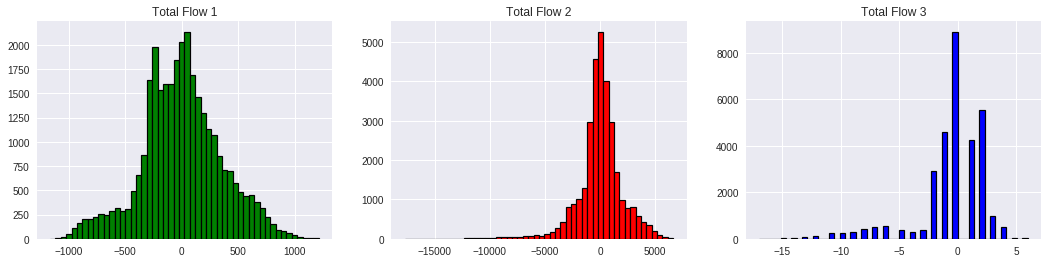

In [28]:
tot_flow1=dist_affconn_mtype - dist_effconn_mtype
tot_flow2= dist_affsyn_mtype - dist_effsyn_mtype
tot_flow3= dist_affsyn_mtype/(dist_effconn_mtype+ dist_affconn_mtype) - dist_effsyn_mtype/(dist_effconn_mtype+ dist_affconn_mtype)
plt.figure(figsize=(18,4))
plt.subplot(1, 3, 1)
plt.hist(tot_flow1,bins=50 ,facecolor='g',edgecolor='black', linewidth=1.2)
plt.title('Total Flow 1')
plt.subplot(1, 3, 2)
plt.hist(tot_flow2,bins=50 ,facecolor='r',edgecolor='black', linewidth=1.2)
plt.title('Total Flow 2')
plt.subplot(1, 3, 3)
plt.hist(tot_flow3,bins=50 ,facecolor='b',edgecolor='black', linewidth=1.2)
plt.title('Total Flow 3')
plt.show()

The accuracy obtained by changing the computatin of the total flow is very similar to the original one:

In [29]:
flab_flow1=labelcreate(tot_flow1,val=np.mean(tot_flow1))
flab_flow2=labelcreate(tot_flow2,val=np.mean(tot_flow2))
flab_flow3=labelcreate(tot_flow3,val=np.mean(tot_flow3))
acc1= (1-float(np.count_nonzero(sign-np.array(flab_flow1)))/N)*100
acc1 = max(acc1,100-acc1)
print('The accuracy in using the sign of the Fiedler vector to classify the neurons Total Flow 1 is {0:.2f}%'.format(acc1))
acc2= (1-float(np.count_nonzero(sign-np.array(flab_flow2)))/N)*100
acc2 = max(acc2,100-acc2)
print('The accuracy in using the sign of the Fiedler vector to classify the neurons Total Flow 2 is {0:.2f}%'.format(acc2))
acc3= (1-float(np.count_nonzero(sign-np.array(flab_flow3)))/N)*100
acc3 = max(acc3,100-acc3)
print('The accuracy in using the sign of the Fiedler vector to classify the neurons Total Flow 3 is {0:.2f}%'.format(acc3))

The accuracy in using the sign of the Fiedler vector to classify the neurons Total Flow 1 is 68.51%
The accuracy in using the sign of the Fiedler vector to classify the neurons Total Flow 2 is 65.52%
The accuracy in using the sign of the Fiedler vector to classify the neurons Total Flow 3 is 65.59%



### **Conclusion**: 
The Fiedler vector doesn't distinguish with very good precision the total flow of the neurons. However this approach shows potential. A possible future direction is finding a more accurate value, such as the processing depth, indicating the strength of the signal-flow through the neurons. 

### 2.4.2) Layers-based clustering


In this section we'll investigate whether the Fiedler vector can spatially separete the neurons. As space separetor we'll use the [6 layers into which the microcolumn is divided ](https://en.wikipedia.org/wiki/Cerebral_cortex). These layers divided the microcolum from the top to the bottom into 6 areas of different size, with different distribution and type of neurons.

In [0]:
## preparing layer labels
m_type=dict()
for i in range(0, len(m_values)):
        m_type[i] =m_values[i] 
num_neuron=dict()
for i in range(0, len(m_values)):
        num_neuron[i]=len(list(h5['populations'][m_type[i]]['locations']))
label_layer=[]
for i in m_type.keys():
  label_layer.extend(num_neuron[i]*list(map(int, re.findall(r'^\D*(\d+)', m_type[i]))))
label_layer = [v if v!= 23 else 2 for v in label_layer]


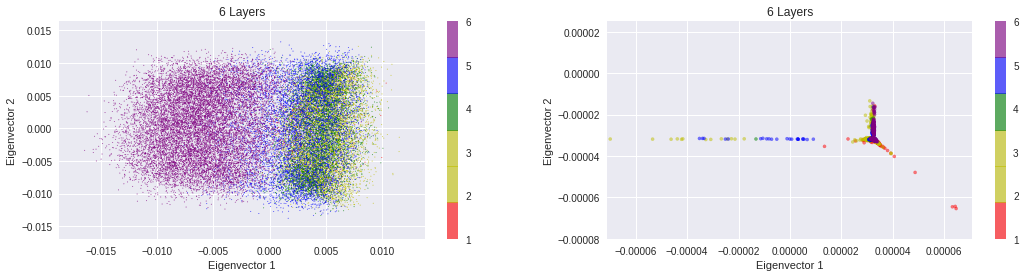

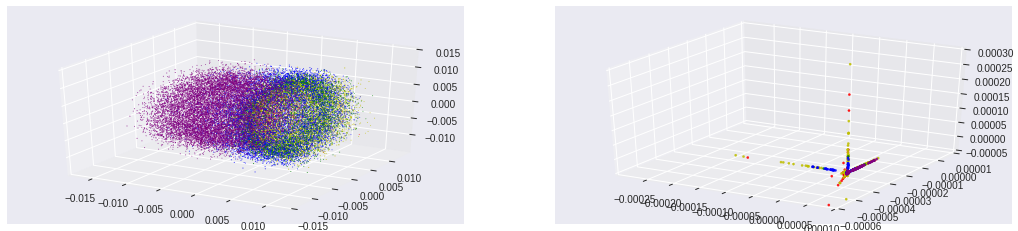

In [31]:
colors = ['r','y','y','g','b','purple']
plt2dembeddings(x_norm,y_norm,x,y, col1=label_layer, col2=label_layer,colmap=col.ListedColormap(colors),size=0.5, title1= '6 Layers', title2='6 Layers')
plt3dembeddings(col=label_layer,colmap=col.ListedColormap(colors))

It looks like the **Fiedler vector of the normalized Laplacian can distinguish neurons in layer 6 from all the other neurons !**

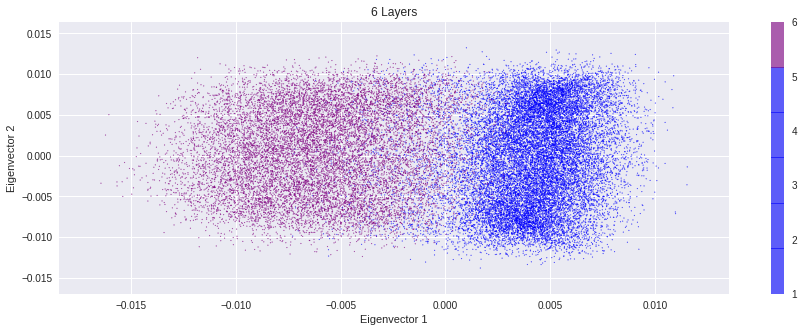

In [32]:
colors = ['b','b','b','b','b','purple']
singleplt2dembeddings(x_norm,y_norm, col1=label_layer,colmap=col.ListedColormap(colors),size=0.8, title1= '6 Layers', )

In [33]:
lab_6=labelcreate(label_layer, val=5) ##pay attention if the sign of the Fiedler vector changes (this is arbitrary)
acc6= (1-float(np.count_nonzero(sign-np.array(lab_6)))/N)*100
acc6 = max(acc6,100-acc6)
print('The accuracy in using the sign of the Fiedler vector to distinguish neuron in layers 6 is {0:.2f}%'.format(acc6))


The accuracy in using the sign of the Fiedler vector to distinguish neuron in layers 6 is 94.76%


In [34]:
acc6KM= (1-float(np.count_nonzero(labnorm-np.array(lab_6)))/N)*100
acc6KM = max(acc6KM,100-acc6KM)
print('The accuracy in using the K-mean partition to distingish neurons in layer 6 is {0:.2f}%'.format(acc6KM))


The accuracy in using the K-mean partition to distingish neurons in layer 6 is 94.66%


**Is this good partition given by the some properties in the degree distribution of layer 6?**

In [0]:
deg6=[tot_degree[i] for i in range(N)if label_layer[i]==6 ]
deg=[tot_degree[i] for i in range(N)if label_layer[i]!=6 ]
dist_affconn_6=[dist_affconn_mtype[i] for i in range(N)if label_layer[i]==6]
dist_effconn_6=[dist_effconn_mtype[i]for i in range(N)if label_layer[i]==6]
dist_affconn_Other=[dist_affconn_mtype[i] for i in range(N)if label_layer[i]!=6]
dist_effconn_Other=[dist_effconn_mtype[i]for i in range(N)if label_layer[i]!=6]
in6=[in_degree[i]for i in range(N)if label_layer[i]==6]
out6=[out_degree[i]for i in range(N)if label_layer[i]==6]
inOther=[in_degree[i]for i in range(N)if label_layer[i]!=6]
outOther=[out_degree[i]for i in range(N)if label_layer[i]!=6]

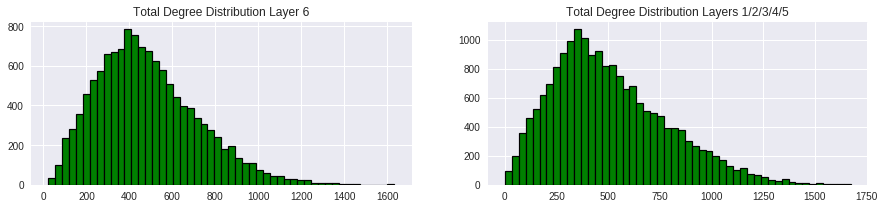

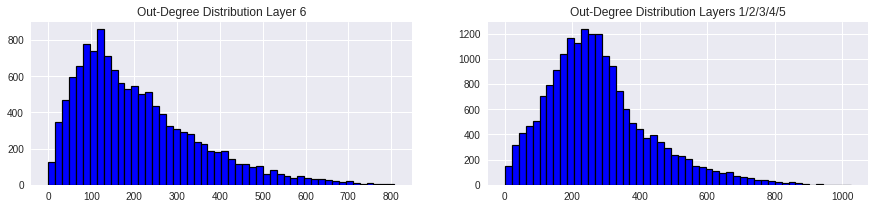

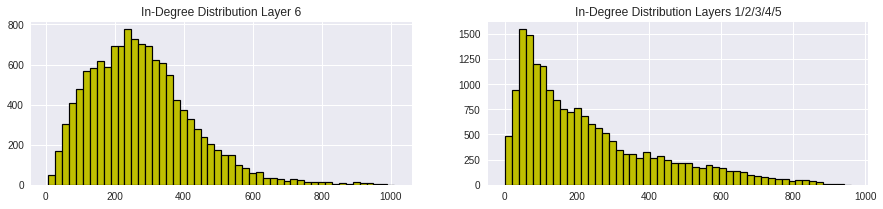

In [36]:
twoplthist(deg6,deg, face='g', tit1='Total Degree Distribution Layer 6',tit2='Total Degree Distribution Layers 1/2/3/4/5')
twoplthist(out6,outOther, face='b', tit1='Out-Degree Distribution Layer 6',tit2='Out-Degree Distribution Layers 1/2/3/4/5')
twoplthist(in6,inOther, face='y', tit1='In-Degree Distribution Layer 6',tit2='In-Degree Distribution Layers 1/2/3/4/5')

**Is there any difference in the distribution if we take into account all connections (removing the border effect)?**

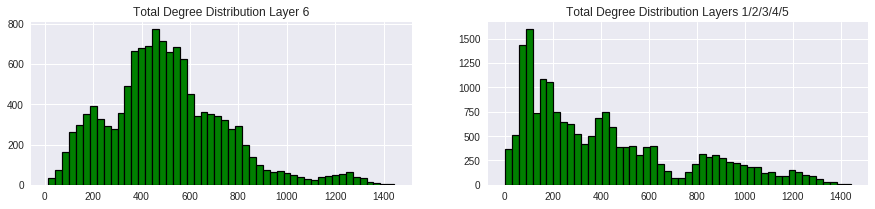

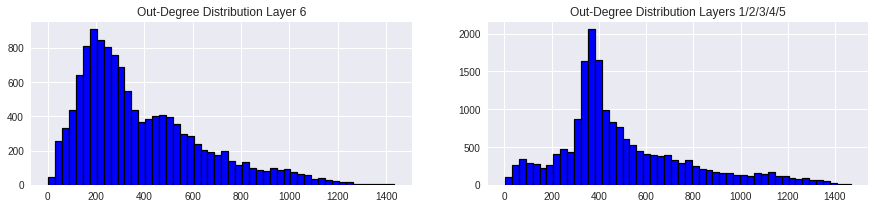

In [37]:
twoplthist(dist_affconn_6,dist_affconn_Other, face='g', tit1='Total Degree Distribution Layer 6',tit2='Total Degree Distribution Layers 1/2/3/4/5')
twoplthist(dist_effconn_6,dist_effconn_Other, face='b', tit1='Out-Degree Distribution Layer 6',tit2='Out-Degree Distribution Layers 1/2/3/4/5')


### Conclusion

Using the sign of the Fiedler vector associated to Laplacian of the connectivity matrix gave us very accurate results in distinguish neurons in layer 6 from all other neurons: the accuracy in distinguishing the 6 layer was the 94.76% . 
 
Using the partition of the weighted network given by the k-mean algorithm gave us similar results: ~94% of accuracy in distinguishing the 6th layer.
 
Moreover, we investigated whether this good accuracy was correlated with the different degree distributions in layer 6 and all other layers. From the histograms one can notice that these distribution don't show remarkable differences between layer 6 and all the other layers.
However, from the clustering based on the total flow one can notice a correlation between layer 6 and a negative total flow.


What this partition tells us is that the optimal cut given by the Cheeger constant is between layer 6 and all the other. In other words connections between layer 6 and all other layers are very weak, and connections inside this two partitions are very dense.  

** Our assumptions and speculations**

Would it be possible that if one 'shut down' during an experiment with volatge layer 1, 2-3, 4, and 5, then layer 6 can still survive like an island in power grid networks?

### 2.4.2) Motif-based spectral clustering

Since directionality of the signal in neural networks plays a crucial role, in this section we explore a new spectral clustering technique that takes into account the direction of the edges in the network.

The recently developed technique is called [motif-based spectral clustering](https://snap.stanford.edu/higher-order/). A motif is one of the 13 possible arrangments of 3 nodes with 3 directed edges. The main idea of motif-based spectral clustering is to fix a motif of interest and build an adjacency matrix by counting the number of times two nodes co-occur in an instance of the motif. Then one can use the first non-trivial eigenvector of the Laplacian associated to the adjacency matrix to find two optimal subsets of nodes which have minimum numbers of motifs connecting them. For a more detailed explanation of the algorithm of motif-based spectral clustering we refer to [Higher-order Organization of Complex Networks (Austin R. Benson, David F. Gleich, and Jure Leskovec, Science)](https://snap.stanford.edu/higher-order/higher-order-science16.pdf)

We choose as a motif the [most recurrent one](https://www.nature.com/articles/nn.4576) in the microcircuit, that is the triangle with a unique source and a unique sink, M5. [The public available code](https://github.com/snap-stanford/snap/tree/master/examples/motifcluster) for motif based spectral clustering has been run on our personal laptop with input the list of edges of the directed graph of the microcircuit.

[Here](https://drive.google.com/file/d/1Ib_oNRR5sZTpi63adaybHp396bAuRBWL/view?usp=sharing) is the link where one can download the edges extracted by us for the directed graph of the microcircuit.

**Run:**

./motifclustermain -i:fulledges_MC.txt -m:M5

**Our output:**

Input directed graph file (-i:)=fulledges_MC.txt

Motif type (-m:)=M5

Cluster output file (-o:)=fulledges_MC-M5-cluster.txt

Largest CC size: 31337

Cluster size: 14797

Motif conductance in largest CC: 0.213391

Eigenvalue: 0.275021



**Remarks:** The largest connected component considering the motif M5 has 31337 points: there are 9 neurons which are outside this component. Since this neurons represent a very small portion of the graph we chose to add them arbitrarly to one of the two clusters.

[Here](https://drive.google.com/file/d/1Xc4hbNhVNjUAFrUEBHInr3vitqq0W81s/view?usp=sharing) one can download the output file 'fulledges_MC-M5-cluster.txt': the first line of the file contains the nodes in the clusters with 14797 points and in the other 9 lines the points outside the largest connected component are listed.

In [0]:
##upload the output file fulledges_MC-M5-cluster.txt
f = open('edges_micorcircuit-M5-cluster.txt', 'r')
x = f.readlines()
motif=[]
with open('edges_micorcircuit-M5-cluster.txt','r') as f:    
    lines = f.readlines()[1:]
    for line in lines:
        elements = line.strip().split("\t")
        motif.append(elements)
motif=[list(map(int, x)) for x in motif]

In [0]:
##create label for the 2 clusters given by motif-clustering
motif_lab=[]
for i in range(N):
  if i in set(motif[0]):
    motif_lab.append(1)
  else:
    motif_lab.append(-1)

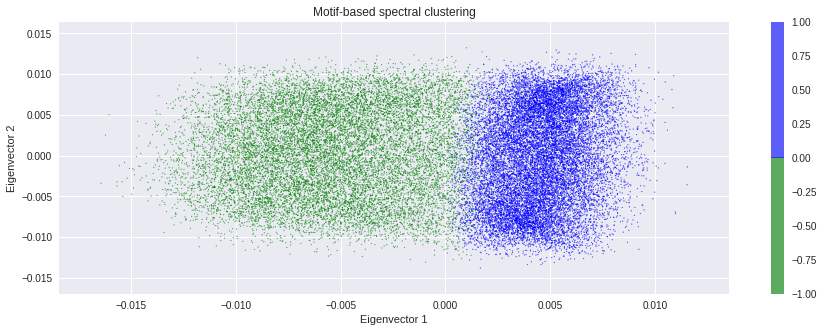

In [40]:
colors = ['g','b']
singleplt2dembeddings(x_norm,y_norm, col1=motif_lab,colmap=col.ListedColormap(colors),size=0.8, title1= 'Motif-based spectral clustering', )

In [41]:
acc_motif= (1-float(np.count_nonzero(np.array(motif_lab)-np.array(lab_6)))/N)*100
acc_motif = max(acc_motif,100-acc_motif)
print('The accurancy of the partition given by motif-based spectral clustering in distinguishing layer 6 is {0:.2f}%'.format(acc_motif))


The accurancy of the partition given by motif-based spectral clustering in distinguishing layer 6 is 94.06%


In fact, the partition given by motif-based spectral clustering is very close to the one given by the fiedler vector.

**Results:**

Our results can be interpreted in the following way: layer 6 and all the other layers form two optimal subsets separeted by a minimal number of triangles in which the edges form a motif with unique source and a unique sink. This consideration should draw attention on how the signal flows between the two partitions. Further investigations for understanding the exchange of information between layer 6 and the other parts of the microcolumn could shade light whether the microcircuit contains areas which behave like islands in power grid networks. This means one tries to make predictions about which areas of the brain might be affected by an injury or a disease by using spectral clustering as it is already done for power grid systems to check which regions would still work in case of a blackout (for reference see [Hierarchical Spectral Clustering of Power Grids](http://ieeexplore.ieee.org/document/6774471/?reload=true)).